In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, ilr_inv, sbp_basis, inner
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
import os

out_dir = os.path.join('figures', '3classes')
os.makedirs(out_dir, exist_ok=True)

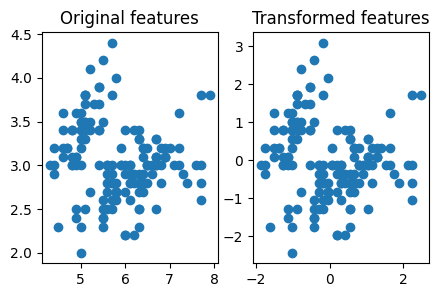

In [3]:
K = 13         #index of the instance you want to test in the test set
N_class = 3    #number of class, the dimension of the simplex is therefore N_class-1


#load the dataset and split into a training and testing set
data = datasets.load_iris()
(X, Y) = (data.data, data.target)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

fig, ax_list = plt.subplots(ncols=2, figsize=(5,3))
ax_list[0].set_title('Original features')
ax_list[0].scatter(X[:,0], X[:,1])
scaler.fit(X)
X = scaler.transform(X)
ax_list[1].set_title('Transformed features')
ax_list[1].scatter(X[:,0], X[:,1])
fig.savefig(os.path.join(out_dir, 'ex_eq3_standardized.pdf'))

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [4]:
#from sklearn.preprocessing import normalize
#fig = plt.figure()
#plt.scatter(X[:,0], X[:,1])
#X = normalize(X, axis=0)
#fig = plt.figure()
#plt.scatter(X[:,0], X[:,1])

In [5]:

#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

#choose an Aitchison orthonormal basis by setting a sequential binary partition matrix.
#If None, the basis obtained with the gram-schmidt procedure is used
sbpmatrix=np.array([[1,-1,0],[1,1,-1]])
basis = sbp_basis(sbpmatrix)

# explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=data.target_names,
                            names_features=['sep. length','sep. width','pet. length','pet. width'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(data.target_names[Y_test[K]])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)



True label of the tested instance: versicolor
Prediction on the simplex: [[0.0123152  0.83858579 0.14909901]]
Prediction in the ILR space: [-2.98461463 -0.31299164]
Sum of the shapley composition and the base distribution in the ILR space: [-2.98461463 -0.31299165]


In [6]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 pet. width: 1.2347638
	 pet. length: 1.0147766
	 sep. width: 0.3602191
	 sep. length: 0.2793581

Projection of the Shapley compositions on the class vectors:
		sep. length	sep. width	pet. length	pet. width	
setosa:   	-0.2725856	-0.3402138	-0.8534179	-0.9930733	
versicolor:	0.1892410	0.0675922	0.9021950	1.1320170	
virginica:	0.0833447	0.2726216	-0.0487771	-0.1389437	

Cosine between each Shapley compositions:
		sep. length	sep. width	pet. length	pet. width	
sep. length:	1.0000000	0.8496474	0.9390149	0.9148250	
sep. width:	0.8496474	1.0000000	0.6164880	0.5643076	
pet. length:	0.9390149	0.6164880	1.0000000	0.9979090	
pet. width:	0.9148250	0.5643076	0.9979090	1.0000000	


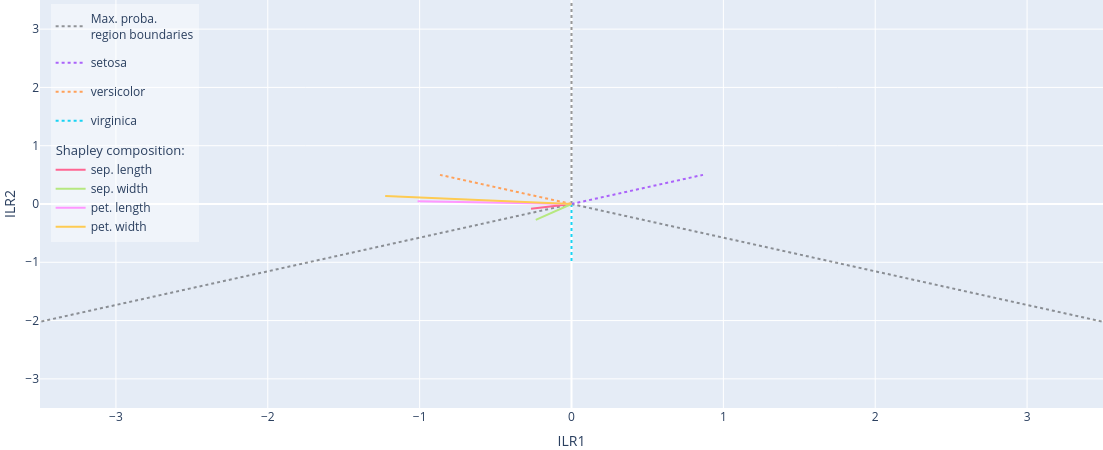

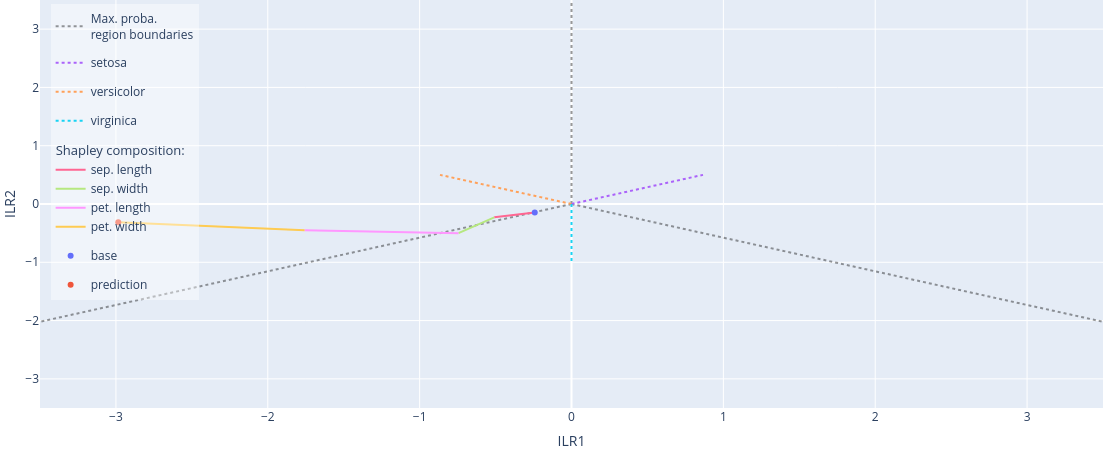

In [9]:
#PLOT the 2D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2], lim=3.5, figsize=450)
fig.write_image(os.path.join(out_dir, 'ex_eq3_ilrplot.pdf'))

fig = explainer.plot_ilr_space(balances=[1, 2], shapley_sum=True, lim=3.5, figsize=450)
fig.write_image(os.path.join(out_dir, 'ex_eq3_ilrplotsum.pdf'))

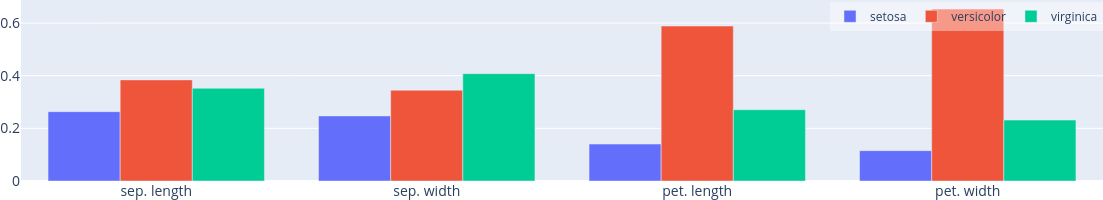

In [8]:
#Plot the Shapley compositions as histograms
fig = explainer.shapley_histogram(figheight=200)
fig.write_image(os.path.join(out_dir, 'ex_eq3_histo.pdf'))